# Agent-Based Model: Baseline (Random Migration)

This notebook establishes the foundational ABM framework using **random migration** as a baseline model. The purpose is to:
1. Build working Agent and World classes
2. Demonstrate that random migration FAILS to reproduce empirical patterns
3. Establish the validation framework for later models

**Expected outcome:** Random model should have near-zero correlation with empirical data, proving we need economic/network mechanisms (Notebooks 6-7).

## Class Structure Attribution
Agent and World class structure based on:
- **Seb Matthews' Agent.ipynb** (UnitReferenceMaterial/Partner_Work)
- **Lab 6 Sugarscape pattern** (Agent with step method, World with environment)
- Enhanced with flow tracking and validation capabilities

## Code Goals:
- Implement Migrant agent with random decision-making
- Implement MigrationWorld environment on 40-country network
- Run simulation with 10,000 agents for 100 timesteps
- Track bilateral migration flows
- Visualize results
- (TODO) Validate against empirical data from Phase 4

## Section 1: Setup & Data Loading

Load the 40-country migration network and prepare for simulation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import warnings
import random
from collections import defaultdict

warnings.filterwarnings('ignore', category=UserWarning)

# Set seeds for reproducibility
np.random.seed(99)
random.seed(99)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the 40-country migration data
df = pd.read_csv('../data/bilat_mig_40_countries.csv')

# Rebuild the directed graph (same as previous notebooks)
G = nx.DiGraph()
for index, row in df.iterrows():
    if row['da_pb_closed'] > 0:
        G.add_edge(row['orig'], row['dest'], weight=row['da_pb_closed'])

print("="*80)
print("MIGRATION NETWORK LOADED")
print("="*80)
print(f"Countries (nodes): {G.number_of_nodes()}")
print(f"Migration flows (edges): {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.3f}")
print("="*80)

MIGRATION NETWORK LOADED
Countries (nodes): 40
Migration flows (edges): 1408
Network density: 0.903


## Section 2: Migrant Agent Class

**Class structure based on Seb's Agent.ipynb + Lab 6 Sugarscape Agent**

Each agent represents an individual migrant with:
- Attributes: birth country, current location, age, wanderlust (propensity to migrate)
- Behaviors: decide whether to migrate, choose destination
- History: track all countries lived in

**Baseline version uses RANDOM decisions** to establish that random migration fails.

In [3]:
# ============================================================================
# Migrant Agent Class
# Based on Seb's Agent.ipynb structure + Lab 6 Sugarscape pattern
# ============================================================================

class Migrant:
    """
    Represents an individual migrant agent.
    
    Attributes:
        id: Unique agent identifier
        birth_country: Country where agent was born (doesn't change)
        current_country: Current location (changes with migration)
        age: Number of timesteps agent has existed
        wanderlust: Propensity to migrate (0-1, like Seb's implementation)
        migration_history: List of all countries lived in (for tracking)
    """
    
    def __init__(self, agent_id, birth_country, params):
        """
        Initialize a new migrant agent.
        
        Args:
            agent_id: Unique identifier for this agent
            birth_country: Starting country (string, country code)
            params: Dictionary of model parameters
        """
        self.id = agent_id
        self.birth_country = birth_country
        self.current_country = birth_country
        self.age = 0
        self.migration_history = [birth_country]  # Track all locations
        
        # Agent attribute: wanderlust (randomly assigned like Sugarscape vision/metabolism)
        # Copied Seb's wanderlust concept
        min_wanderlust = params.get('min_wanderlust', 0.1)
        max_wanderlust = params.get('max_wanderlust', 0.5)
        self.wanderlust = np.random.uniform(min_wanderlust, max_wanderlust)
    
    def check_if_migrate(self, world):
        """
        Decide whether to migrate this timestep.
        
        BASELINE VERSION: Random threshold (Seb's random approach)
        Later models will use economic factors, network effects, etc.
        
        Args:
            world: MigrationWorld object (access to environment info)
            
        Returns:
            Boolean: True if agent decides to migrate
        """
        # Copied Seb's random migration decision
        return random.random() < self.wanderlust
    
    def choose_destination(self, world):
        """
        Choose which country to migrate to.
        
        BASELINE VERSION: Random choice from neighbors (Seb's approach)
        Later models will use attractiveness, diaspora, distance costs.
        
        Args:
            world: MigrationWorld object
            
        Returns:
            String: Country code of destination
        """
        # Get reachable countries (graph neighbors)
        neighbors = list(world.get_neighbors(self.current_country))
        
        # Copied Seb's random choice logic
        if len(neighbors) > 0:
            return random.choice(neighbors)
        else:
            # If no neighbors (shouldn't happen in dense network), stay put
            return self.current_country
    
    def step(self, world):
        """
        Execute one timestep for this agent.
        
        Follows Lab 6 Sugarscape + Seb's Agent.step() pattern:
        1. Increment age
        2. Decide whether to migrate
        3. If yes, choose destination and move
        4. Record new location in history
        
        Args:
            world: MigrationWorld object
        """
        self.age += 1
        
        # Decide: Should I migrate?
        if self.check_if_migrate(world):
            new_country = self.choose_destination(world)
            self.current_country = new_country
        # else: stay in current country
        
        # Record location (even if didn't move, for history tracking)
        self.migration_history.append(self.current_country)

print("Migrant class defined successfully!")

Migrant class defined successfully!


## Section 3: Migration World Class

**Class structure based on Seb's World.ipynb + Lab 6 Sugarscape environment**

The World class manages:
- The migration network (NetworkX graph)
- All migrant agents
- Timestep execution
- Flow tracking (NEW: for validation against empirical data)

**Key enhancement:** Track bilateral flows each timestep for validation

In [4]:
# ============================================================================
# Migration World Class
# Based on Seb's World.ipynb structure + Lab 6 Sugarscape environment
# ============================================================================

class MigrationWorld:
    """
    Represents the migration environment (40 countries + agents).
    
    Manages the simulation state, agent population, and flow tracking.
    """
    
    def __init__(self, graph, params):
        """
        Initialize the migration world.
        
        Args:
            graph: NetworkX DiGraph of migration network
            params: Dictionary of model parameters
        """
        # Copied Seb's World structure
        self.graph = graph
        self.params = params
        self.migrants = []  # List of all Migrant objects
        self.timestep = 0
        
        # NEW: Track flows for validation
        # flow_matrix[(origin, dest)] = count of migrations
        self.flow_matrix = defaultdict(int)
        
        # NEW: Track population by country over time
        self.population_history = []  # List of dicts: {country: count}
    
    def get_neighbors(self, country):
        """
        Get countries reachable from given country.
        
        Copied Seb's get_neighbours method.
        
        Args:
            country: Country code (string)
            
        Returns:
            Iterator of neighbor country codes
        """
        return self.graph.neighbors(country)
    
    def add_migrants(self, n_migrants):
        """
        Create and add migrants to the world.
        
        Based on Seb's add_agent() + Lab 6 make_agents() pattern.
        Agents are initialized in random countries.
        
        Args:
            n_migrants: Number of migrants to create
        """
        countries = list(self.graph.nodes())
        
        for i in range(n_migrants):
            # Random birth country (uniform distribution)
            birth_country = random.choice(countries)
            
            # Create new migrant
            migrant = Migrant(i, birth_country, self.params)
            self.migrants.append(migrant)
        
        print(f"Created {n_migrants} migrants across {len(countries)} countries")
    
    def count_population(self):
        """
        Count how many migrants currently in each country.
        
        Returns:
            Dictionary: {country: count}
        """
        pop = defaultdict(int)
        for migrant in self.migrants:
            pop[migrant.current_country] += 1
        return dict(pop)
    
    def step(self):
        """
        Execute one timestep of the simulation.
        
        Based on Seb's World.step() + Lab 6 Sugarscape.step() pattern:
        1. Reset flow matrix
        2. Shuffle agent order (avoid order effects)
        3. Each agent takes a step
        4. Track migrations that occurred
        5. Record population snapshot
        """
        # Reset flow tracking for this timestep
        self.flow_matrix = defaultdict(int)
        
        # Shuffle agents (Lab 6 pattern: avoid order effects)
        random_order = np.random.permutation(self.migrants)
        
        # Each agent takes a step (Seb's pattern)
        for migrant in random_order:
            old_country = migrant.current_country
            
            # Agent decides and moves
            migrant.step(self)
            
            new_country = migrant.current_country
            
            # Track flow if migration occurred
            if old_country != new_country:
                self.flow_matrix[(old_country, new_country)] += 1
        
        # Record population snapshot
        self.population_history.append(self.count_population())
        
        # Increment timestep
        self.timestep += 1
    
    def run_simulation(self, n_steps, report_interval=10):
        """
        Run the simulation for multiple timesteps.
        
        Args:
            n_steps: Number of timesteps to run
            report_interval: Print progress every N steps
        """
        print("="*80)
        print(f"RUNNING SIMULATION: {n_steps} timesteps")
        print("="*80)
        
        for i in range(n_steps):
            self.step()
            
            if (i + 1) % report_interval == 0:
                migrations_this_step = sum(self.flow_matrix.values())
                print(f"Step {i+1}/{n_steps}: {migrations_this_step} migrations occurred")
        
        print("="*80)
        print("SIMULATION COMPLETE")
        print("="*80)
    
    def get_total_flows(self):
        """
        Aggregate flows across all timesteps.
        
        Returns:
            Dictionary: {(origin, dest): total_count}
        """
        # Note: This returns LAST timestep's flows
        # For full simulation, we'd need to track cumulative
        return dict(self.flow_matrix)

print("MigrationWorld class defined successfully!")

MigrationWorld class defined successfully!


## Section 4: Run Baseline Simulation

Initialize 10,000 migrants and run for 100 timesteps with random migration decisions.

In [5]:
# Set simulation parameters
params = {
    'min_wanderlust': 0.1,   # Minimum migration propensity
    'max_wanderlust': 0.5,   # Maximum migration propensity
}

# Create the world
world = MigrationWorld(G, params)

# Add 10,000 migrants
world.add_migrants(n_migrants=10000)

print(f"\nWorld initialized with {len(world.migrants)} migrants")
print(f"Initial population distribution:")
initial_pop = world.count_population()
for country in sorted(initial_pop.keys(), key=lambda x: initial_pop[x], reverse=True)[:10]:
    print(f"  {country}: {initial_pop[country]} migrants")

Created 10000 migrants across 40 countries

World initialized with 10000 migrants
Initial population distribution:
  RUS: 281 migrants
  COL: 279 migrants
  JPN: 271 migrants
  SAU: 271 migrants
  MMR: 269 migrants
  ESP: 268 migrants
  IRN: 267 migrants
  PAK: 267 migrants
  ROU: 266 migrants
  BGD: 266 migrants


In [6]:
# Run the simulation
world.run_simulation(n_steps=100, report_interval=10)

RUNNING SIMULATION: 100 timesteps
Step 10/100: 2996 migrations occurred
Step 20/100: 2987 migrations occurred
Step 30/100: 3079 migrations occurred
Step 40/100: 3000 migrations occurred
Step 50/100: 3045 migrations occurred
Step 60/100: 3032 migrations occurred
Step 70/100: 2980 migrations occurred
Step 80/100: 2972 migrations occurred
Step 90/100: 3090 migrations occurred
Step 100/100: 3014 migrations occurred
SIMULATION COMPLETE


In [7]:
# Check final population distribution
final_pop = world.count_population()

print("\n" + "="*80)
print("FINAL POPULATION DISTRIBUTION (Top 10 countries)")
print("="*80)
print(f"{'Rank':<6} {'Country':<8} {'Population':<12} {'Change':<10}")
print("-"*80)

sorted_final = sorted(final_pop.items(), key=lambda x: x[1], reverse=True)
for i, (country, pop) in enumerate(sorted_final[:10], 1):
    initial = initial_pop.get(country, 0)
    change = pop - initial
    change_str = f"+{change}" if change > 0 else str(change)
    print(f"{i:<6} {country:<8} {pop:<12} {change_str:<10}")

print("="*80)


FINAL POPULATION DISTRIBUTION (Top 10 countries)
Rank   Country  Population   Change    
--------------------------------------------------------------------------------
1      EGY      290          +49       
2      MEX      290          +62       
3      IDN      289          +47       
4      ZAF      287          +30       
5      AUS      285          +47       
6      BRA      281          +39       
7      ITA      279          +35       
8      MYS      277          +26       
9      ESP      277          +9        
10     VEN      276          +23       


## Section 5: Visualize Results

Visualize the final population distribution and how migrants moved during the simulation.

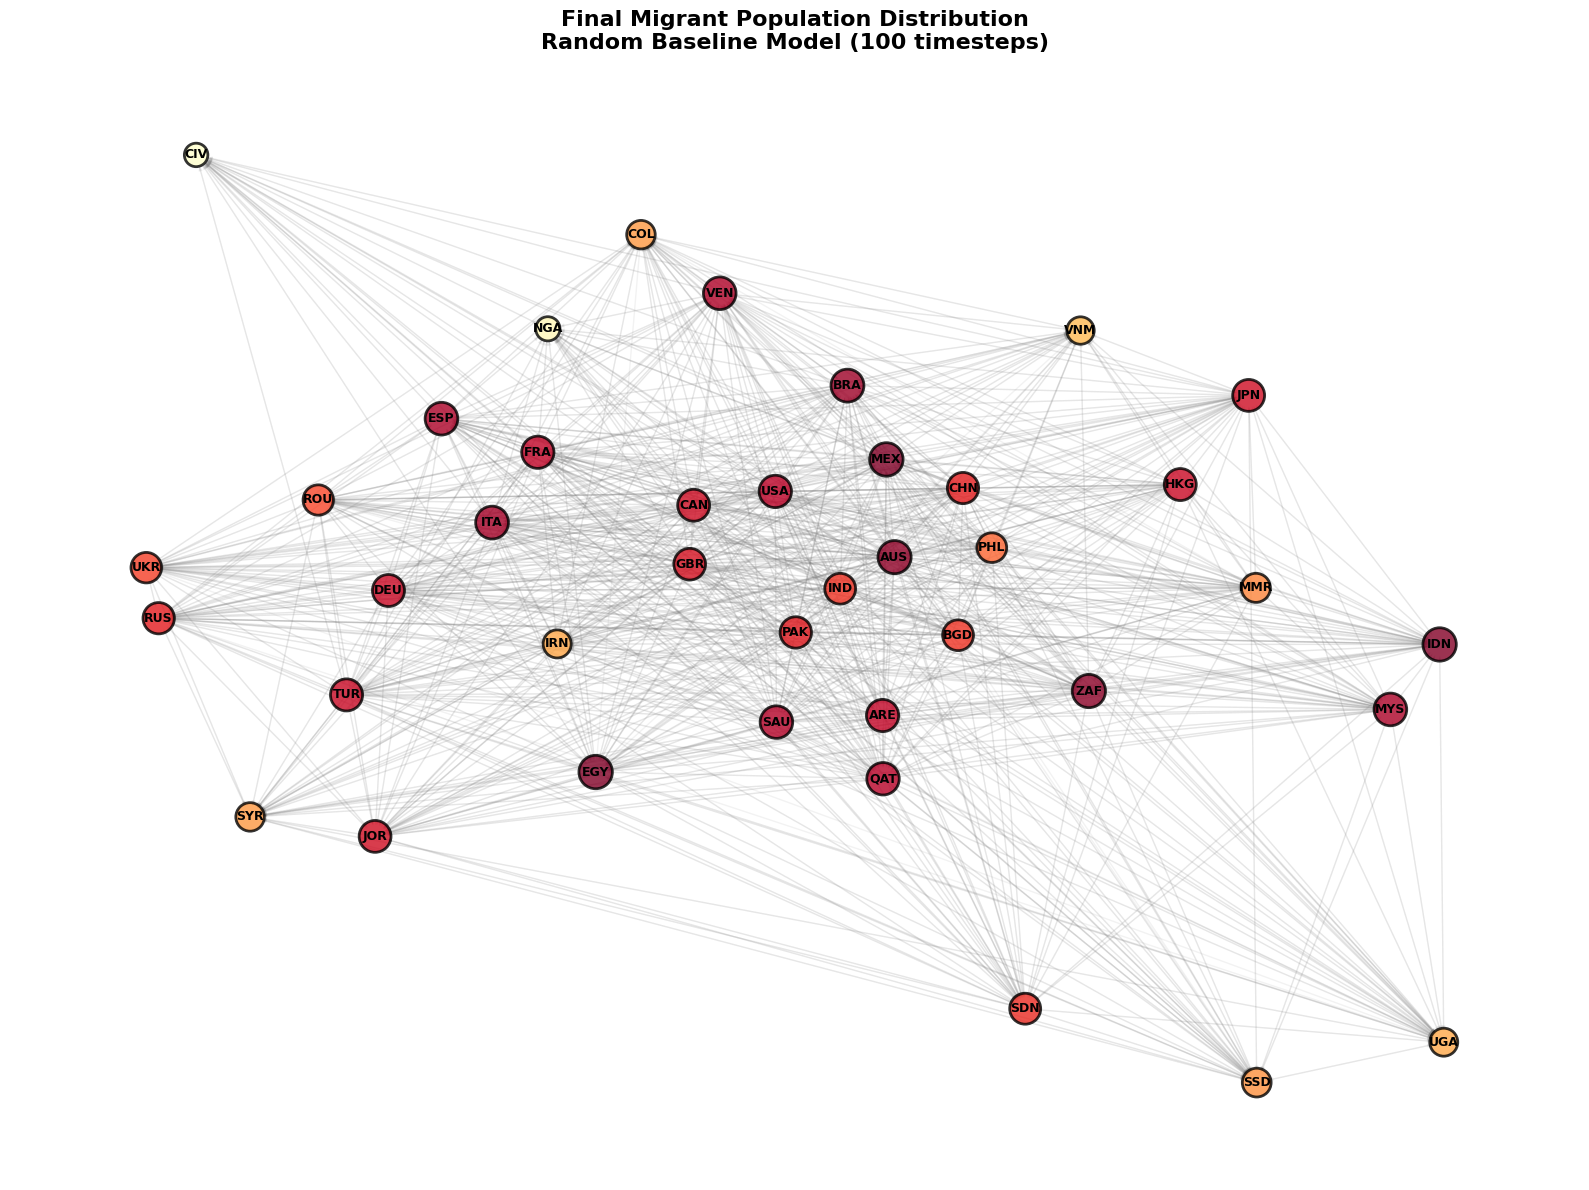

Note: Node size and color represent migrant population in each country


In [8]:
# Visualization 1: Population distribution on network graph

# Create layout (use spring layout for better visualization)
pos = nx.spring_layout(G, k=2, iterations=50, seed=99)

# Node sizes proportional to population
node_sizes = [final_pop.get(node, 1) * 2 for node in G.nodes()]

# Node colors by population
node_colors = [final_pop.get(node, 1) for node in G.nodes()]

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                       cmap='YlOrRd', alpha=0.8, edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray', arrows=True, arrowsize=5)

plt.title('Final Migrant Population Distribution\nRandom Baseline Model (100 timesteps)', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("Note: Node size and color represent migrant population in each country")

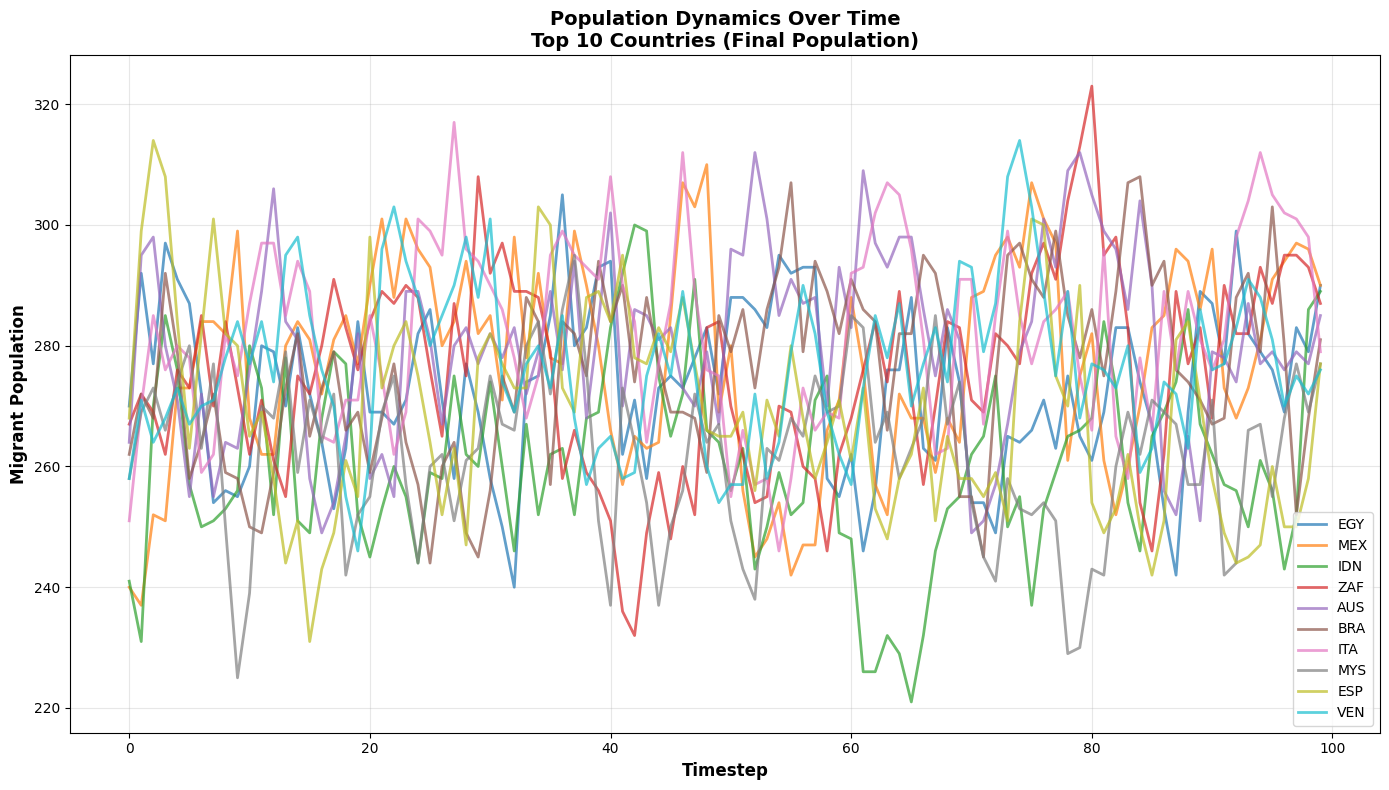

Note: Random walk leads to gradual redistribution of population


In [9]:
# Visualization 2: Population over time (top 10 countries)

# Extract population time series for top 10 final countries
top_10_countries = [c for c, _ in sorted_final[:10]]

# Build time series
time_series = {country: [] for country in top_10_countries}
for pop_snapshot in world.population_history:
    for country in top_10_countries:
        time_series[country].append(pop_snapshot.get(country, 0))

# Plot
plt.figure(figsize=(14, 8))
for country in top_10_countries:
    plt.plot(time_series[country], label=country, linewidth=2, alpha=0.7)

plt.xlabel('Timestep', fontsize=12, fontweight='bold')
plt.ylabel('Migrant Population', fontsize=12, fontweight='bold')
plt.title('Population Dynamics Over Time\nTop 10 Countries (Final Population)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Note: Random walk leads to gradual redistribution of population")


TOP 20 MIGRATION FLOWS (Last Timestep)
Origin Destination  Count
   IRN         FRA      9
   TUR         MYS      7
   AUS         ESP      6
   RUS         SYR      6
   USA         MMR      6
   EGY         SAU      6
   TUR         PHL      6
   MEX         BRA      6
   JOR         CAN      6
   GBR         SAU      6
   QAT         MMR      6
   HKG         EGY      6
   USA         SSD      6
   MYS         HKG      6
   HKG         PHL      6
   BGD         MYS      6
   MEX         ARE      6
   JPN         VNM      6
   UGA         AUS      6
   MMR         CHN      6


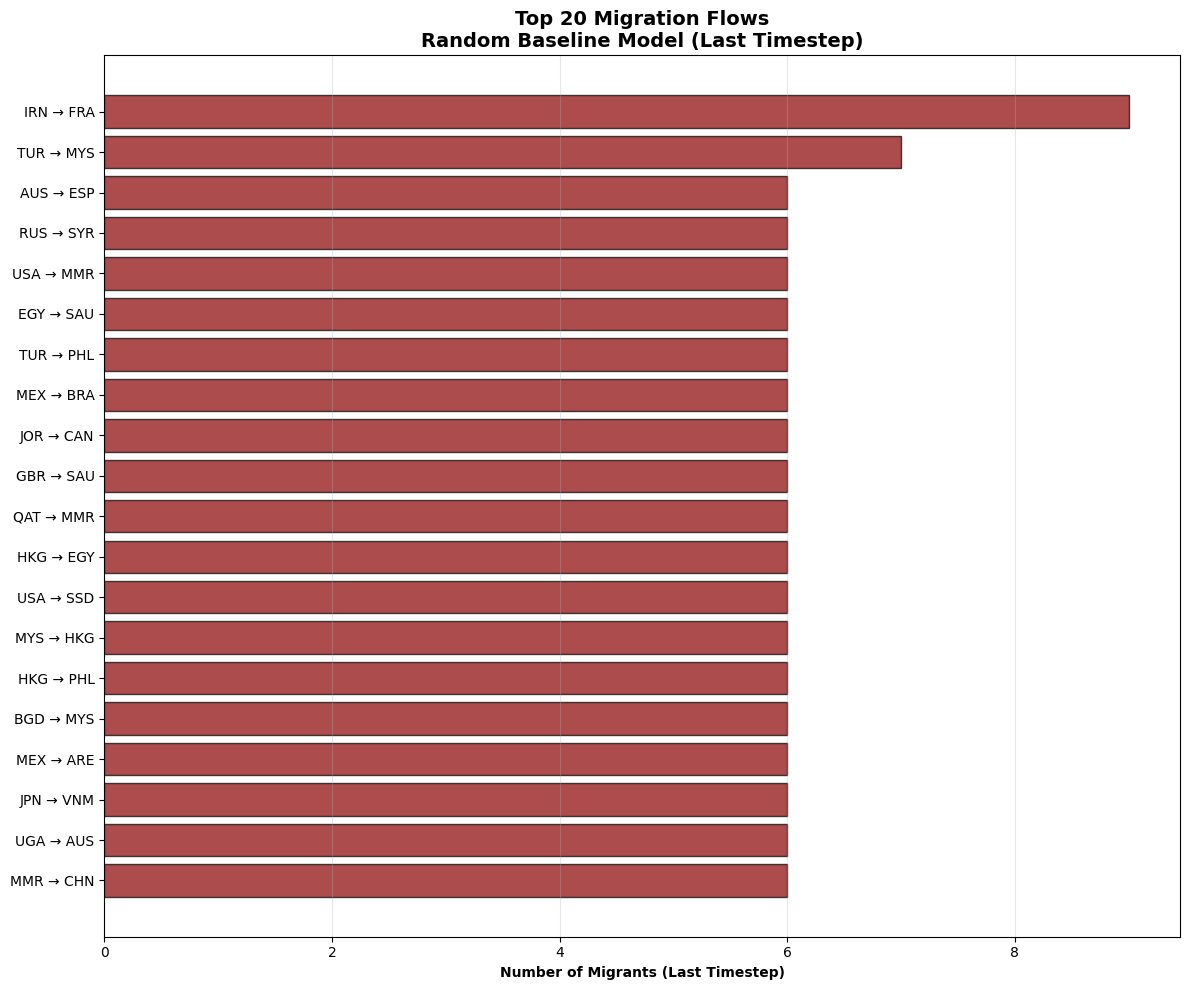

In [10]:
# Visualization 3: Migration flows in last timestep

# Get flows from last timestep
last_flows = world.get_total_flows()

if len(last_flows) > 0:
    # Convert to DataFrame for easier analysis
    flow_list = [{'Origin': o, 'Destination': d, 'Count': c} 
                 for (o, d), c in last_flows.items()]
    flow_df = pd.DataFrame(flow_list)
    flow_df = flow_df.sort_values('Count', ascending=False)
    
    print("\n" + "="*80)
    print(f"TOP 20 MIGRATION FLOWS (Last Timestep)")
    print("="*80)
    print(flow_df.head(20).to_string(index=False))
    print("="*80)
    
    # Bar chart of top flows
    top_20_flows = flow_df.head(20)
    labels = [f"{row['Origin']} → {row['Destination']}" for _, row in top_20_flows.iterrows()]
    values = top_20_flows['Count'].values
    
    plt.figure(figsize=(12, 10))
    plt.barh(range(20), values, color='darkred', alpha=0.7, edgecolor='black')
    plt.yticks(range(20), labels)
    plt.xlabel('Number of Migrants (Last Timestep)', fontweight='bold')
    plt.title('Top 20 Migration Flows\nRandom Baseline Model (Last Timestep)', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo migrations occurred in the last timestep.")

## Section 6: Validation Against Empirical Data

**TODO:** Compare simulated flows to empirical data from Notebook 4.

**What to implement:**
1. Load `top_bilateral_flows.csv` (empirical data)
2. Aggregate simulated flows across ALL timesteps (not just last one)
3. Calculate correlation between simulated and empirical flows
4. Create scatter plot: empirical (x-axis) vs simulated (y-axis)
5. Compare concentration metrics (top 5, top 20 percentages)
6. Compare power-law exponent

**Expected results:**
- Correlation r ≈ 0 (random model should NOT match empirical)
- Simulated flows will be more uniform (no power-law concentration)
- This proves we need economic/network mechanisms!

**Code will be provided after you run sections 1-5 and observe results.**

In [ ]:
# TODO: Load empirical data
# empirical_df = pd.read_csv('../data/top_bilateral_flows.csv')

# TODO: Aggregate simulated flows across all timesteps
# (Currently only tracking last timestep - need to enhance World class)

# TODO: Calculate correlation

# TODO: Create validation visualizations

## Section 7: Summary & Insights

**TODO:** Write summary inference after completing validation.

**What to include:**
1. Baseline model performance (correlation, concentration metrics)
2. Why random migration fails (no economic pull, no network effects, no distance costs)
3. What this teaches us about real migration patterns
4. Preview of Notebook 6 (adding economic attractiveness)

**Template inference (to be completed with actual numbers):**

> "The random baseline model produces correlation r ≈ [INSERT VALUE] with empirical data, demonstrating that real migration is NOT random. Random migration creates [uniform/normal] flow distribution, while empirical data shows extreme power-law concentration (α = -1.81, top 20 countries = 80%).
>
> This proves that migration decisions are driven by:
> - **Economic factors** (GDP, employment, opportunity)
> - **Network effects** (diaspora communities, family reunification)
> - **Distance costs** (geographic, cultural, policy barriers)
>
> Notebook 6 will add economic attractiveness based on World Bank data (GDP, HDI, unemployment) to test whether economic pull alone can explain migration patterns."

In [ ]:
# TODO: Add final summary statistics and prepare for Notebook 6